# Evaluation

**Is the algoritmically generated score accurate? That is, how precisely does it compare to the original? In this notebook we compare the reconstruction and the original in detail.**

## Introduction

In [1]:
import music21
from music21 import converter
from music21.stream import Part, Score, Measure
from music21.instrument import Soprano, Alto, Tenor, Bass
from music21.interval import Interval

from copy import deepcopy
from collections import Counter

In [2]:
original = converter.parse('../scores/Summa.musicxml', storePickle=False)
reconstruction = converter.parse('../scores/Summa-reconstruction.musicxml', storePickle=False)

In [3]:
def compare_two_parts(original, reconstruction, measure_num, parts=[0,1]):
    p1, p2 = parts
    part1 = deepcopy(original.measure(measure_num).parts[p1])
    part1.partName = f'{part1.id[0]}. (orig)'
    part1[1].remove(part1[1].getElementsByClass('RehearsalMark').first())
    part2 = deepcopy(original.measure(measure_num).parts[p2])
    part2.partName = f'{part2.id[0]}. (orig)'

    part3 = deepcopy(reconstruction.measure(measure_num).parts[p1])
    part3.partName = f'{part3.id[0]}. (algo)'
    part4 = deepcopy(reconstruction.measure(measure_num).parts[p2])
    part4.partName = f'{part4.id[0]}. (algo)'

    # Create score
    fragment = Score()
    fragment.append([part1, part2, part3, part4])

    # Add brackets
    sg1 = music21.layout.StaffGroup([part1, part2], symbol='bracket')
    sg2 = music21.layout.StaffGroup([part3, part4], symbol='bracket')
    fragment.insert(0, sg1)
    fragment.insert(0, sg2)
    
    return fragment

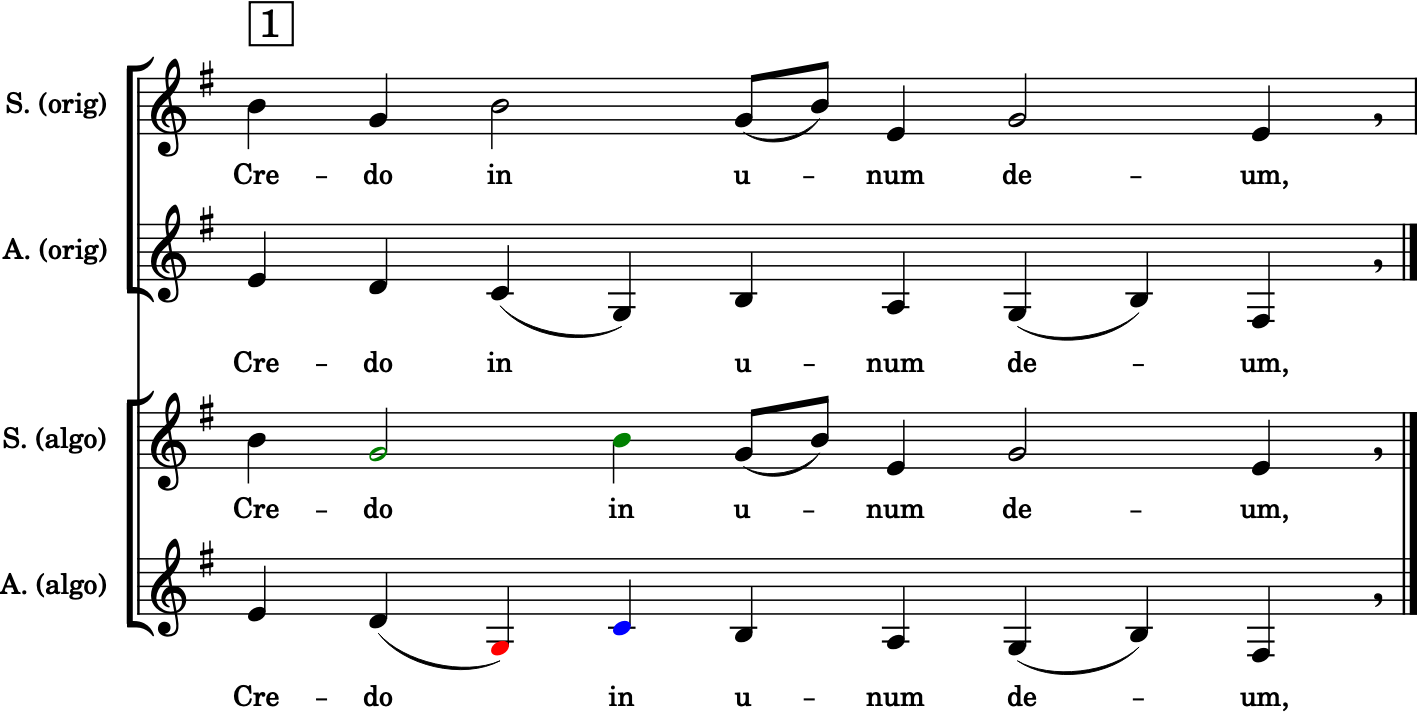

PosixPath('/Users/Bas/repos/projects/recomposing-part/figures/evaluation-error-types/evaluation-error-types.musicxml')

In [4]:
fragment = compare_two_parts(original, reconstruction, 1)

n2 = fragment.parts[1].recurse().notes
n3 = fragment.parts[2].recurse().notes
n4 = fragment.parts[3].recurse().notes
n3[1].style.color = 'green' # duration
n3[2].style.color = 'green' # duration
n4[2].style.color = 'red'   # insertion
n4[3].style.color = 'blue'  # deletion

fragment.show()
fragment.write(fp='../figures/evaluation-error-types/evaluation-error-types.musicxml')

Here we compare the first bar of the original score (top two staffs) and the algorithmic reconstruction (bottom two staffs). In the first bar, only the soprano and alto sing, so we omit the tenor and bass. If we look at the second and third syllable (*-do in*), we find four errors in the reconstruction: those notes have been colored. The colors correspond to different types of errros.

1. **Ornament insertion (red).** The third note of the reconstructed alto has an ornament (G3) that we do not find in the original. We call this error an *ornament insertion*.
2. **Ornament deletion (blue).** The fourth note (C4, syllable *in*), on the other hand, is ornamented in the original, but not in the reconstruction. This we call an *ornament deletion*.
3. **Duration errors (green).** In the soprano part we see two duration errors: the second note (G4, *-do*) has double the duration of the original, and the third note (B4, *in*) half the duration of the original, but both are otherwise correct. We call these *duration errors*. In this piece, durations are completely determined the melodic voices and ornamentation, which means that duration erros will always be caused by ornament insertions or deletions. In the exaple, the insertion error causes the first duration error, and the deletion error causes the second duration error. And so in a way, counting both insertions/deletions *and* duration errors means you are counting errors twice. For that reason we will largely ignore duration errors.
4. **Pitch errors (orange, not shown).** Finally, it could be that a note has the wrong pitch, although that is not the case in this example.

In the example, the ornament insertions and deletions where in a melody voice, but they of course also appear in tintinnabuli voices. In measure two, the tenor part for example has an ornament insertion and deletion:

In [5]:
def compare_part(original, reconstruction, measure_num, part):
    fragment = Score()
    part1 = deepcopy(original.measure(measure_num).parts[part])
    part1.partName = f'{part1.id[0]}. (orig)'
    part2 = deepcopy(reconstruction.measure(measure_num).parts[part])
    part2.partName = f'{part2.id[0]}. (algo)'
    fragment.append([part1, part2])
    return fragment

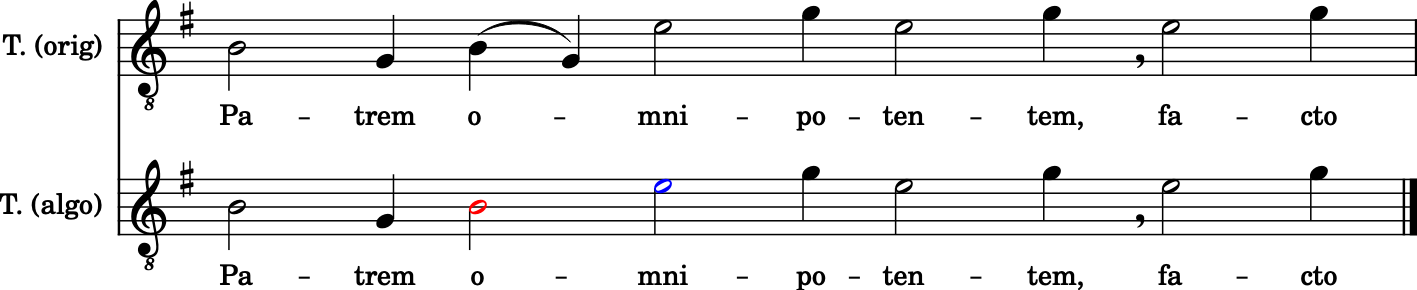

In [6]:
# Combine original and reconstructed tenor parts in measure 2
fragment = compare_part(original, reconstruction, 2, 2)
n2 = fragment.parts[1].recurse().notes
n2[2].style.color = 'red'
n2[3].style.color = 'blue'
fragment.show()

Based on these two examples, one might propose that we have missed a regularity. In both cases, the note with an insertion is followed immediately by a deletion. Differently put, the ornament is shifted to the next syllable. Should we introduce another rule to account for these deviations? 

To find out which deviations might be explained by regularities, we systematically evaluate the reconstructed score we have produced.
That means that we compare the original to the reconstruction part by part, syllable by syllable, identify all errors, and categorize them in the four error types listed above.
We ignore the final two bars in this error analysis, as those break some of the regularities observed in the rest of the piece.

## Automatic evaluation

In [7]:
def group_syllables(stream):
    """Create a nested list of syllables, where each syllable is a list of notes"""
    syllables = []
    syll = []
    for note in stream.flat.notes:
        if len(note.lyrics) == 0:
            syll.append(note)
        else:
            if len(syll) > 0:
                syllables.append(syll)
            syll = [note]
            
    if len(syll) > 0:
        syllables.append(syll)
    return syllables

In [8]:
def note_error(note, message, color='cyan'):
    """Store an error message in the editorial information of a note, 
    and color the note accordingly"""
    note.editorial['error'] = True
    if 'messages' not in note.editorial:
        note.editorial['messages'] = []
    note.editorial['messages'].append(message)
    note.editorial['color'] = color
    note.style.color = color

In [9]:
def evaluate_notes(note1, note2):
    """Verify that the second note is the same as the first and if not, report
    the error in the editorial information"""
    # Check lyrics
    if note1.lyric != note2.lyric:
        # Should not occur
        note_error(note2, f'lyrics: "{note2.lyric}" instead of "{note1.lyric}"', 'yellow')
    
    # Check durations
    if note1.quarterLength != note2.quarterLength:
        note_error(note2, f'duration: {note2.quarterLength} instead of {note1.quarterLength}', 'green')
        
    # Check pitch
    if note1.nameWithOctave != note2.nameWithOctave:
        note_error(note2, f'pitch: {note2.nameWithOctave} instead of {note1.nameWithOctave}', 'orange')

In [10]:
def evaluate_score(original, reconstruction, start_measure=1, end_measure=49):
    score1 = original
    score2 = deepcopy(reconstruction)
    for part1, part2 in zip(score1.parts, score2.parts):
        assert part1.id == part2.id
        for m in range(start_measure, end_measure):
            syllables1 = group_syllables(part1.measure(m))
            syllables2 = group_syllables(part2.measure(m))

            if not len(syllables1) == len(syllables2):
                # This should only happen in the final measure
                if m != 48:
                    print(f'Different number of syllables in measure {m}')
                
            for syl1, syl2 in zip(syllables1, syllables2):
                if len(syl1) == len(syl2):
                    # Same number of notes for this syllable
                    for note1, note2 in zip(syl1, syl2):
                        evaluate_notes(note1, note2)

                elif len(syl1) > len(syl2):
                    # Reconstructed syllable is shorter
                    evaluate_notes(syl1[0], syl2[0])
                    note_error(syl2[0], 'deletion: Original has ornaments', 'blue')

                elif len(syl1) < len(syl2):
                    # Reconstructed syllable is longer: ornament too many
                    evaluate_notes(syl1[0], syl2[0])
                    note_error(syl2[1], 'insertion: Ornament does not appear in original', 'red')
    
    return score2.measures(start_measure, end_measure)

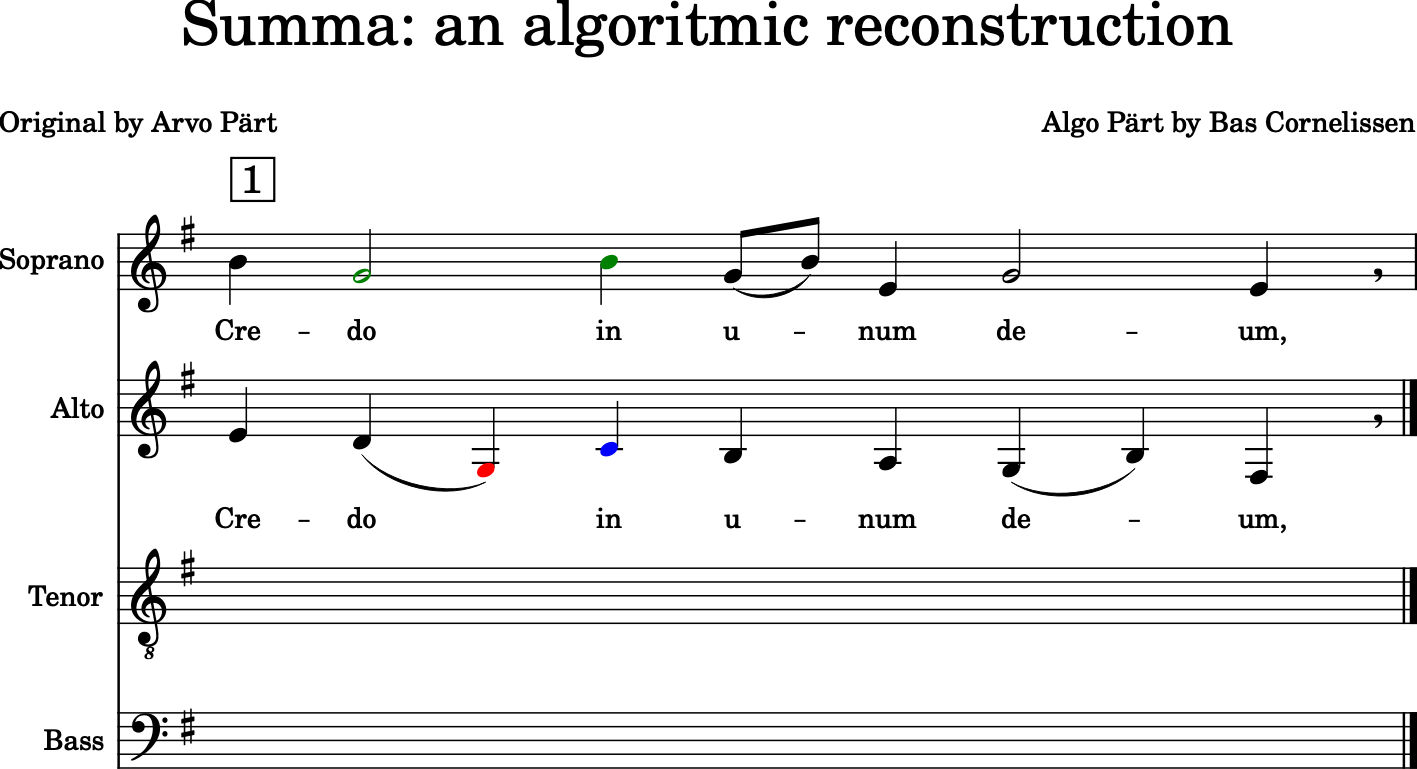

In [11]:
evaluation = evaluate_score(original, reconstruction)
evaluation.write(fp='../scores/Summa-evaluation.musicxml')
evaluation.measure(1).show()

The automatic evaluation colors the errors in the same way as in the example shown earlier. This makes it easier to go through the score and manually analyze the errors. We however also conduct a quantitative analysis. Before we do so, we need to look at the ending.

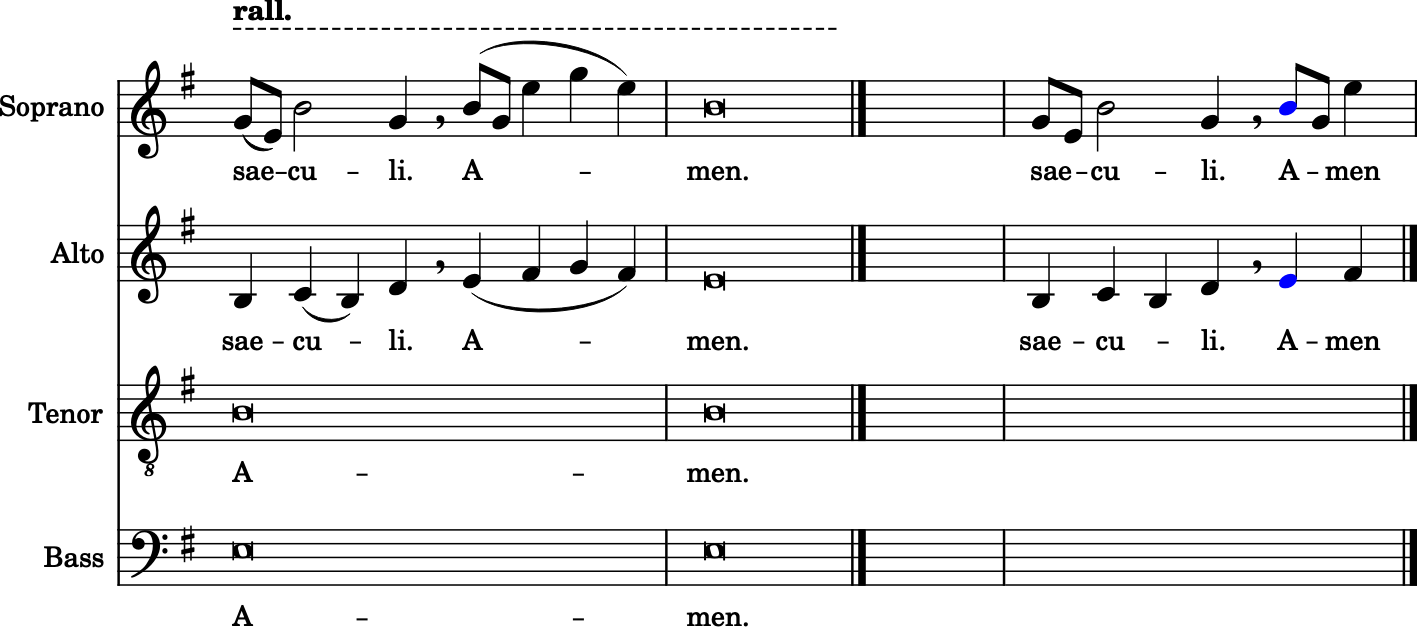

PosixPath('/Users/Bas/repos/projects/recomposing-part/figures/summa-ending/summa-ending.musicxml')

In [12]:
ending = Score()
ending.append([deepcopy(p) for p in original.measures(48, 50).parts])
for part in ending.parts:
    part.append(music21.stream.Measure())
    m = music21.stream.Measure()
    r_part = evaluation.parts[part.id]
    m.append([deepcopy(el) for el in r_part.measure(48)])
    part.append(m)

ending.show()
ending.write(fp='../figures/summa-ending/summa-ending.musicxml')

The score above compares the original score (left) with the reconstructed score (right). Since the final measures are more freely composed, the rules that apply to the rest of the score don't work so well here. That also applies to the error types: we actually see here 6 _note deletions_ (in the 2 in the tenor and bass on 'A', and 4 on the final 'men'). Alternatively, you could count the 'men' in the alto and soprano as a pitch error. But to keep things simple, we will treat all errors as ornament deletions: 3 in both the alto and soprano, and 2 in both the tenor and bass. The automatic evaluation will detect only two ornament deletions (highlighted in blue), and so we manually add 8 more insertion errors to the analyses.

In [13]:
ending_errors = dict(insertion=8)

In [14]:
def stat(title, count, total, total_label):
    print(f'{title: <25} {count: >5} out of {total: >4} {total_label: <6}  ({count/total:>2.1%})')
    
def analyze(score, report=True, additional_counts=dict()):
    counts = Counter(additional_counts)
    notes = list(score.recurse().notes)
    errors = sum(counts.values())
    non_duration_errors = counts['insertion'] + counts['deletion'] + counts['pitch']

    for note in notes:
        if not 'error' in note.editorial: 
            continue
            
        messages = [m for m in note.editorial['messages']]
        if len(messages) > 0:
            errors += 1
            for message in messages:
                counts[message.split(':')[0]] += 1

        non_duration_messages = [m for m in messages if not m.startswith('duration:')]
        if len(non_duration_messages) > 0:
            non_duration_errors += 1
    
    if report:
        stat('Total number of errors', errors, len(notes), 'notes')
        stat('1. Ornament deletions',  counts['deletion'],  errors, 'errors')
        stat('2. Ornament insertions', counts['insertion'], errors, 'errors')
        stat('3. Duration errors',     counts['duration'],  errors, 'errors')
        stat('4. Pitch errors',        counts['pitch'],     errors, 'errors')
        print('—'*60)
        stat('>> Non-duration errors', non_duration_errors, len(notes), 'notes')
    
    return counts, errors, non_duration_errors

In [15]:
analyze(evaluation, additional_counts=ending_errors);

Total number of errors      106 out of 1288 notes   (8.2%)
1. Ornament deletions        15 out of  106 errors  (14.2%)
2. Ornament insertions       34 out of  106 errors  (32.1%)
3. Duration errors           60 out of  106 errors  (56.6%)
4. Pitch errors               2 out of  106 errors  (1.9%)
————————————————————————————————————————————————————————————
>> Non-duration errors       51 out of 1288 notes   (4.0%)


In [16]:
# Statistics on the regular part, i.e. without the final measures
analyze(evaluation.measures(1, 47));

Total number of errors       96 out of 1275 notes   (7.5%)
1. Ornament deletions        13 out of   96 errors  (13.5%)
2. Ornament insertions       26 out of   96 errors  (27.1%)
3. Duration errors           60 out of   96 errors  (62.5%)
4. Pitch errors               2 out of   96 errors  (2.1%)
————————————————————————————————————————————————————————————
>> Non-duration errors       41 out of 1275 notes   (3.2%)


## Regular adjustments

The previous section shows that our algorithmic reconstruction is fairly accurate: it correctly reproduces over 90% of the notes. Amongst all errors, most are duration errors caused by faulty ornaments. Excluding those, we see that fewer than 3% of the notes need to be corrected in order to faithfully reproduce the full score. We now take a closer look at those notes, and look for any plausible regularities. We think of these as final adjustments to an overall fair reconstruction of the score.

### Make notes removable

In [17]:
def num_measures(score):
    """Computes the total number of measures in a score"""
    return len(score.parts[0].recurse(classFilter='Measure'))

In [18]:
def offset_to_measure_mapping(score):
    return {
        score.parts[0].measure(m).offset: m 
        for m in range(1, num_measures(score)+1) }

In [19]:
def is_ornament(note):
    return len(note.lyrics) == 0

def set_duration(note, duration, context=None):
    difference = duration - note.quarterLength
    if context is None:
        context = note.getContextByClass('Measure')
    context.shiftElements(difference, 
                          startOffset=note.offset + note.quarterLength, 
                          classFilterList=['Note'])
    note.quarterLength = duration

def half_duration(note):
    set_duration(note, note.quarterLength/2)
    
def double_duration(note):
    set_duration(note, note.quarterLength * 2)

In [20]:
def clean_slurs(score):
    for slur in score.recurse(classFilter='Slur'):
        for n in slur.getSpannedElements():
            if n.activeSite is None:
                slur.activeSite.remove(slur)

In [21]:
def remove_note(note, score):
    offset_to_measure_number = offset_to_measure_mapping(score)
    number = offset_to_measure_number[note.activeSite.offset]
    part = note.getContextByClass('Part')
    
    if is_ornament(note):
        if part.id in ['Soprano', 'Tenor']:
            previous = note.previous('Note')
            part.measure(number).remove(note, shiftOffsets=False)
            previous.quarterLength = note.quarterLength + previous.quarterLength

        else:
            # Group all notes per syllable
            syllables = {}
            for p in score.parts:
                measure = p.measure(number)
                syllables[p.id] = group_syllables(measure)

            # Find the position: syllable number
            pos, j = None, 0
            while pos is None:
                syl = syllables[part.id][j]
                for n in syl:
                    if n is note:
                        pos = j
                j += 1

            # Remove the note from the syllable
            syllables[part.id][pos] = syllables[part.id][pos][:-1]
            context = score.parts[part.id].measure(number)
            context.remove(note, shiftOffsets=True)

            # Recompute all durations
            bass_dur = 0 if len(syllables['Bass']) == 0 else len(syllables['Bass'][pos])
            alto_dur = 0 if len(syllables['Alto']) == 0 else len(syllables['Alto'][pos])                   
            duration = max(bass_dur, alto_dur)
            
            if duration == 1:
                for p in ['Alto', 'Bass']:
                    if len(syllables[p]) > 0:
                        context = score.parts[p].measure(number)
                        set_duration(syllables[p][pos][0], 1, context=context)

                for p in ['Soprano', 'Tenor']:
                    if len(syllables[p]) > 0:
                        notes = syllables[p][pos]
                        context = score.parts[p].measure(number)
                        for n in notes:
                            set_duration(n, duration / len(notes), context=context)
                
                # Update time signatures
                for p in score.parts:
                    ts = p.measure(number).getElementsByClass('TimeSignature').first()
                    ts.numerator -= 1
                            
            else:
                set_duration(note.previous(), 2)

    else:
        raise NotImplemented()
    
def clean_score(score):
    score.purgeOrphans()
    clean_slurs(score)
    
# score = deepcopy(reconstruction)
# note = list(score.parts[1].measure(12).notes)[5]
# remove_note(note, score)

### Adjustment: avoid ornamental exits

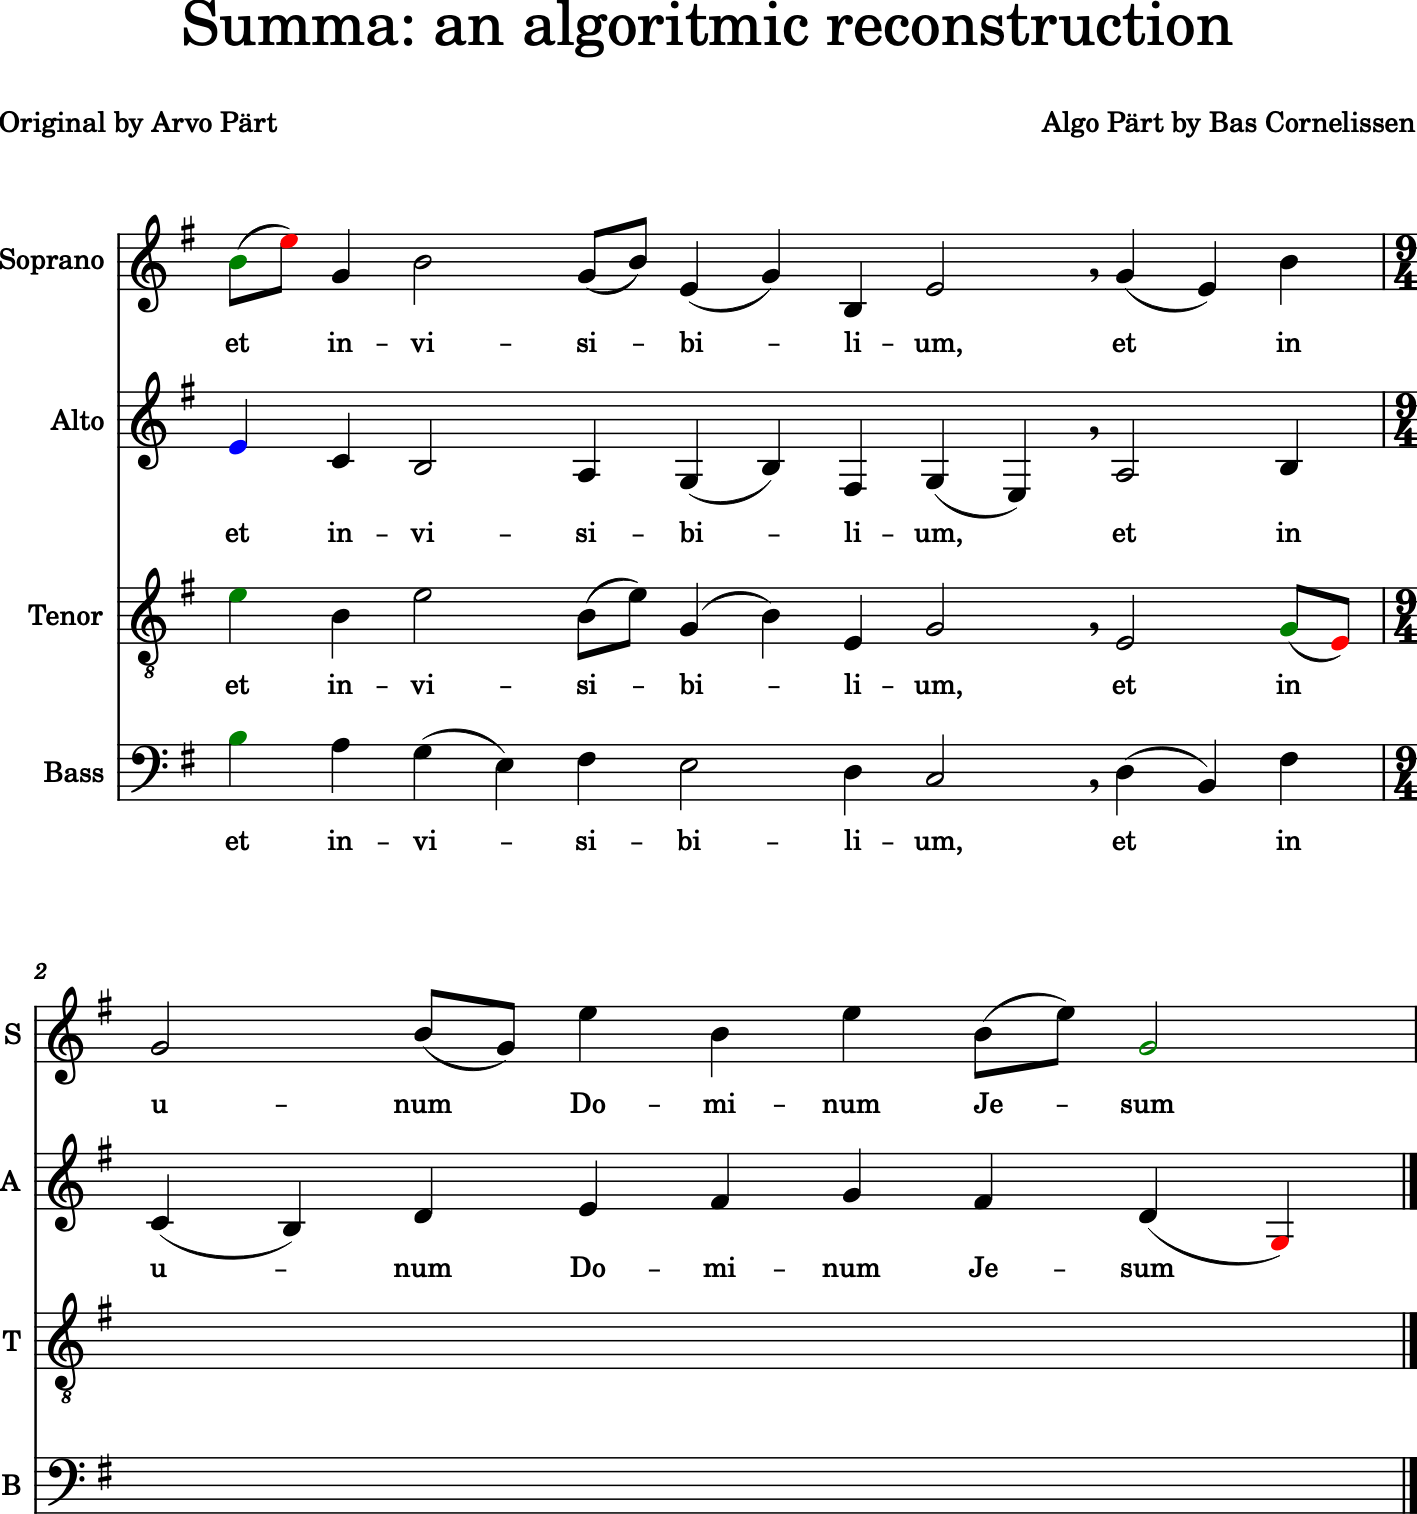

In [22]:
evaluation.measures(5, 6).show()

Some of erroneous ornaments are found just before a voice exits. In the example above, the last note of the tenor (E, on *in*) has an ornament in the reconstruction, but Pärt seems to have removed this. In fact, whenever the last note of a voice before a rest is an ornament, it has bee consistently removed. We introduce this as a regular adjustment.

In [23]:
def remove_ornamental_exits(score, report=True):
    offset_to_measure_number = offset_to_measure_mapping(score)
    count = 0
    for m in range(1, num_measures(score)):
        for part in score.parts:
            measure = part.measure(m)
            next_measure = part.measure(m+1)
            cur_length = len(measure.recurse().notes)
            next_length = len(next_measure.recurse().notes)
            if cur_length > 0 and next_length == 0:
                final = measure.recurse().notes[-1]
                if is_ornament(final):
                    count += 1
                    remove_note(final, score)
                    if report:
                        print(f'{count}. Removed ornament in {part.id}, measure {m}, beat {final.offset + 1}')

    if report:
        print('—'*70)                
        print(f'>  {count} ornaments at voice exits removed')

without_exits = deepcopy(reconstruction)
remove_ornamental_exits(without_exits)
clean_score(without_exits)

1. Removed ornament in Tenor, measure 5, beat 1.0
2. Removed ornament in Bass, measure 17, beat 1.0
3. Removed ornament in Bass, measure 23, beat 1.0
4. Removed ornament in Soprano, measure 26, beat 1.0
5. Removed ornament in Alto, measure 32, beat 1.0
6. Removed ornament in Bass, measure 47, beat 1.0
——————————————————————————————————————————————————————————————————————
>  6 ornaments at voice exits removed


In [ ]:
evaluation_without_exits = evaluate_score(original, without_exits)
evaluation_without_exits.write(fp='../scores/Summa-evaluation-adjusted.musicxml')

In [43]:
analyze(evaluation, additional_counts=ending_errors);

Total number of errors      106 out of 1288 notes   (8.2%)
1. Ornament deletions        15 out of  106 errors  (14.2%)
2. Ornament insertions       34 out of  106 errors  (32.1%)
3. Duration errors           60 out of  106 errors  (56.6%)
4. Pitch errors               2 out of  106 errors  (1.9%)
————————————————————————————————————————————————————————————
>> Non-duration errors       51 out of 1288 notes   (4.0%)


In [44]:
analyze(evaluation_without_exits, additional_counts=ending_errors);

Total number of errors       86 out of 1282 notes   (6.7%)
1. Ornament deletions        15 out of   86 errors  (17.4%)
2. Ornament insertions       28 out of   86 errors  (32.6%)
3. Duration errors           46 out of   86 errors  (53.5%)
4. Pitch errors               2 out of   86 errors  (2.3%)
————————————————————————————————————————————————————————————
>> Non-duration errors       45 out of 1282 notes   (3.5%)


In [46]:
100-6.7

93.3

### Soprano

In [25]:
analyze(evaluation_without_exits.parts[0], additional_counts=dict(insertion=2));

Total number of errors       34 out of  329 notes   (10.3%)
1. Ornament deletions         2 out of   34 errors  (5.9%)
2. Ornament insertions        7 out of   34 errors  (20.6%)
3. Duration errors           24 out of   34 errors  (70.6%)
4. Pitch errors               1 out of   34 errors  (2.9%)
————————————————————————————————————————————————————————————
>> Non-duration errors       10 out of  329 notes   (3.0%)


### Alto

In [26]:
analyze(evaluation_without_exits.parts[1], additional_counts=dict(insertion=2));

Total number of errors       22 out of  317 notes   (6.9%)
1. Ornament deletions         9 out of   22 errors  (40.9%)
2. Ornament insertions        9 out of   22 errors  (40.9%)
3. Duration errors            4 out of   22 errors  (18.2%)
4. Pitch errors               1 out of   22 errors  (4.5%)
————————————————————————————————————————————————————————————
>> Non-duration errors       19 out of  317 notes   (6.0%)


### Tenor

In [27]:
analyze(evaluation_without_exits.parts[2], additional_counts=dict(insertion=2));

Total number of errors       17 out of  303 notes   (5.6%)
1. Ornament deletions         4 out of   17 errors  (23.5%)
2. Ornament insertions        3 out of   17 errors  (17.6%)
3. Duration errors           14 out of   17 errors  (82.4%)
4. Pitch errors               0 out of   17 errors  (0.0%)
————————————————————————————————————————————————————————————
>> Non-duration errors        7 out of  303 notes   (2.3%)


### Bass

In [28]:
analyze(evaluation_without_exits.parts[3], additional_counts=dict(insertion=2));

Total number of errors       13 out of  333 notes   (3.9%)
1. Ornament deletions         0 out of   13 errors  (0.0%)
2. Ornament insertions        9 out of   13 errors  (69.2%)
3. Duration errors            4 out of   13 errors  (30.8%)
4. Pitch errors               0 out of   13 errors  (0.0%)
————————————————————————————————————————————————————————————
>> Non-duration errors        9 out of  333 notes   (2.7%)


### Plot

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from utils import *

In [30]:
import matplotlib
matplotlib.style.use('styles.mplstyle')

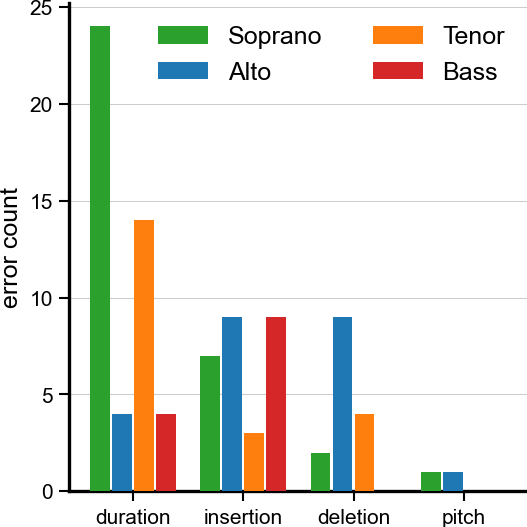

In [31]:
def plot_errors_per_part(score):
    labels = ['duration', 'insertion', 'deletion', 'pitch'] 
    xs = np.arange(len(score.parts))
    width = 1 / (len(xs) + 1)
    colors = dict(S='C2', A='C0', T='C1', B='C3')
    for i, part in enumerate(score.parts):
        counts, _, _ = analyze(part, report=False, additional_counts=dict(insertion=2))
        c = [counts[l] for l in labels]
        plt.bar(xs + i * width, c, 
                width=.9 * width, 
                label=part.id,
                color=colors[part.id[0]], zorder=10)
    
    plt.xticks(xs+.3, labels);
#     plt.xlabel('error type')
    plt.ylabel('error count')
    plt.legend(ncol=2)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

plt.subplots(1, figsize=cm2inch(5, 5), tight_layout=True)
plt.grid(axis='y', zorder=-1, c='.8', lw=.25)
plt.yticks(np.arange(0, 26, 5))
plot_errors_per_part(evaluation_without_exits)
plt.savefig('../figures/evaluation-error-counts/evaluation-error-counts-raw.pdf')

### Uncovered adjustments?

A few ornamental errors still remain, but I cannot discern a clear pattern anymore, other than that quite some insertions fall in one of the first two syllables of a measure. 